# Second Hand Cars - Marketplace
## Data Cleaning & Analysis

In [1]:
# Adjust Notebook Display
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# Imports

# General Data Analysis
import pandas as pd
import numpy as np

# Text Based Libraries
import re
import nltk
import gensim
import emoji
from nltk.stem import SnowballStemmer   
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import Created Custom Functions from other files
from ipynb.fs.full.TextFunctions import log_progress, abbr_or_lower, tokenize, find_words, get_feature, spell_check

In [4]:
# Load Scraped Data
marketplace = pd.read_csv('marketplace_cars.csv')
print('Facebook Marketplace Dataframe Size :', marketplace.shape)
marketplace.head()

Facebook Marketplace Dataframe Size : (682, 5)


,Title,Price,Locality,Description,Condition
0,🚨🚨Cars For Sale 🚨🚨,4999.0,Żejtun,📞📞77226444,Used - like new
1,Renault Megane Scenic 16 Petrol Automatic . Ta...,2750.0,Munxar,Plate is garaged. Ta Malta . Vrt every 2 years...,Used - Good
2,Suzuki swift,4800.0,Birkirkara,Suzuki swift in good condition 2008,NaN
3,99882200,4500.0,Birkirkara,FOR SALE MOB 📞📞 99882200 TOYOTA VITZ AUTOMATIC...,NaN
4,Car for sale,3000.0,Marsaskala,If you are interested dm me,NaN


<b>NOTES</b>
1. Presence of emojies in text. The types of emojies used appear to be included for attracting attention rather than conveying additional information. Hence, emojies can be easily removed rather than converted to text (demojized).
2. Text appears to be highly unclean. Having a spell check is likely to help to account for excess variation in text.
3. Car condition was sometime referenced in text but necessarily labeled in the container on Marketplace.

In [5]:
# Quick Analysis
marketplace.describe(include = 'all')

,Title,Price,Locality,Description,Condition
count,682,6.800000e+02,682,654,206
unique,588,NaN,52,606,3
top,Car,NaN,Żebbuġ,"Peugeot 308 2008 model 56,638km 1.6L petrol M...",Used - Good
freq,6,NaN,54,2,110
mean,NaN,1.923705e+05,NaN,NaN,NaN
std,NaN,1.263828e+06,NaN,NaN,NaN
min,NaN,1.000000e+03,NaN,NaN,NaN
25%,NaN,2.800000e+03,NaN,NaN,NaN
50%,NaN,4.800000e+03,NaN,NaN,NaN
75%,NaN,8.800000e+03,NaN,NaN,NaN


High degree of variation visible in price variable. Upper bound appears to be excessively high. This is seen as a behaviour of users when the intention is to give a price on request. Other users would write unbelievably low prices when having the same goal of giving a proper price on request.

Description Column also appears to have duplicates. These should be removed.

In [6]:
# Quick Check of Nulls
marketplace.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        682 non-null    object 
 1   Price        680 non-null    float64
 2   Locality     682 non-null    object 
 3   Description  654 non-null    object 
 4   Condition    206 non-null    object 
dtypes: float64(1), object(4)
memory usage: 26.8+ KB


Nulls related to price can be easily removed, whilst imputation methods based in text analysis should be used for the Description and Condition columns.

### Tackle Main Nulls of Concern

In [7]:
# Drop Rows with Nulls in Price 
marketplace = marketplace.dropna(subset = ['Price'])

In [8]:
# Combine Title and Description Columns (Combine useful information and limits nulls in description column)
marketplace['Text'] = marketplace['Title'] + ' ' + marketplace['Description']

In [9]:
# If Description is Null, use Title Only as Text
marketplace['Text'] = np.where(marketplace['Text'].isnull(), marketplace['Title'], marketplace['Text'])

In [10]:
# Drop Duplicates in Text Column
marketplace = marketplace.drop_duplicates(subset = ['Text'])

In [11]:
# Check Impacts of Transformations
marketplace.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 0 to 681
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        624 non-null    object 
 1   Price        624 non-null    float64
 2   Locality     624 non-null    object 
 3   Description  606 non-null    object 
 4   Condition    190 non-null    object 
 5   Text         624 non-null    object 
dtypes: float64(1), object(5)
memory usage: 34.1+ KB


The remaining issue is the 'Condition' variable. Some imputation is possible from the 'Text' column, but this requires text cleaning and pre-processing.

### Price Distribution

In [12]:
# Price Variable Descriptive Statistics
marketplace['Price'].describe()

count    6.240000e+02
mean     1.939183e+05
std      1.280082e+06
min      1.000000e+03
25%      2.750000e+03
50%      4.700000e+03
75%      8.425000e+03
max      9.999999e+06
Name: Price, dtype: float64

Price distribution does not appear to have changed post initial steps of data cleaning.

In [13]:
# Remove Excessively High Prices
marketplace = marketplace[marketplace['Price'] < 70000]
print('Dataframe Size without Excessively High Prices :', marketplace.shape)

Dataframe Size without Excessively High Prices : (604, 6)


In [14]:
# Price Variable New Descriptive Statistics
marketplace['Price'].describe()

count      604.000000
mean      6654.470199
std       6988.237566
min       1000.000000
25%       2700.000000
50%       4500.000000
75%       7800.000000
max      58000.000000
Name: Price, dtype: float64

Price distribution appears more realistic.

### Text Analysis

In [15]:
# Remove Emojies from Text
marketplace['Text_Clean'] = marketplace['Text'].apply(lambda s: emoji.replace_emoji(s, ''))

In [16]:
# Apply Spell Check Function
marketplace['Text_Clean'] = [spell_check(listing) for listing in log_progress(marketplace['Text_Clean'])]

In [17]:
# Apply More Thorough Text Cleaning - Lemmatization
marketplace['Text_Clean'] = [tokenize(listing, 2) for listing in log_progress(marketplace['Text_Clean'])]

Text pre-processing function has three main options: lowercase, stemming and lemmatization. Lemmatization option because it transforms different conjucations to the root word, given that lowercase still leaves a large room for variation in text and stemming could be too aggressive in processing text.

#### Assess Unigrams, Bigrams and Trigrams in Text

To get meaningful keywords and phrases from the text several options fpr the parameters max_df and min_df were tested. Playing with the parameter max_df had little value due to the low incidence of terms. Adjusting min_df was more fruitful. Several options were tried, such as 0.5, 0.25, 0.2, 0.1, 0.09, 0.075, 0.05, 0.025, 0.02, 0.01, 0.009.

In [18]:
# Instanciate TfidfVectorizer (tokenizer set to iterate over documents/paragraphs)
tfidf1 = TfidfVectorizer(ngram_range=(1, 1), tokenizer=lambda doc: doc, min_df=0.075, lowercase=False) # Unigrams
tfidf2 = TfidfVectorizer(ngram_range=(2, 2), tokenizer=lambda doc: doc, min_df=0.025, lowercase=False) # Bigrams
tfidf3 = TfidfVectorizer(ngram_range=(3, 3), tokenizer=lambda doc: doc, min_df=0.01, lowercase=False) # Trigrams

In [19]:
# Analyse Unigrams
tfidf_text = tfidf1.fit_transform(marketplace['Text_Clean'])
d1 = pd.DataFrame.sparse.from_spmatrix(tfidf_text, columns=tfidf1.get_feature_names_out())
list(d1.columns) # Show Unigrams

['ac',
 'air',
 'auto',
 'automatic',
 'bmw',
 'car',
 'central',
 'cheap',
 'condition',
 'contact',
 'diesel',
 'door',
 'electric',
 'engine',
 'euro',
 'extra',
 'gearbox',
 'good',
 'import',
 'japan',
 'leather',
 'licence',
 'license',
 'low',
 'malta',
 'manual',
 'mile',
 'mileage',
 'model',
 'negotiable',
 'new',
 'owner',
 'paid',
 'perfect',
 'petrol',
 'power',
 'price',
 'seat',
 'serviced',
 'steering',
 'ta',
 'till',
 'toyota',
 'vrt',
 'window',
 'year']

In [20]:
# Analyse Bigrams
tfidf_text = tfidf2.fit_transform(marketplace['Text_Clean'])
d2 = pd.DataFrame.sparse.from_spmatrix(tfidf_text, columns=tfidf2.get_feature_names_out())
list(d2.columns) # Show Bigrams

['address contact',
 'air condition',
 'alloy wheel',
 'ask mile',
 'auto dealer',
 'car facebook',
 'central lock',
 'cheap license',
 'climate control',
 'condition power',
 'condition viewing',
 'contact car',
 'dealer malta',
 'diesel manual',
 'electric window',
 'engine petrol',
 'everthing work',
 'excellent condition',
 'extra air',
 'facebook address',
 'facebook page',
 'fixed forever',
 'good condition',
 'japan import',
 'leather seat',
 'licence paid',
 'license paid',
 'low license',
 'manual gearbox',
 'manual transmission',
 'message facebook',
 'mint condition',
 'monthly payment',
 'new tyre',
 'old registration',
 'owen auto',
 'page owen',
 'paid till',
 'parking sensor',
 'perfect condition',
 'petrol automatic',
 'petrol manual',
 'pls send',
 'power steering',
 'price euro',
 'price negotiable',
 'registrade malta',
 'send message',
 'shall beg',
 'ta malt',
 'ta malta',
 'toyota vitz',
 'viewing pls',
 'work perfect']

In [21]:
# Analyse Trigrams
tfidf_text = tfidf3.fit_transform(marketplace['Text_Clean'])
d3 = pd.DataFrame.sparse.from_spmatrix(tfidf_text, columns=tfidf3.get_feature_names_out())
list(d3.columns) # Show Trigrams

['address contact car',
 'air condition power',
 'appointment car car',
 'auto dealer malta',
 'automatic good condition',
 'car facebook page',
 'car good condition',
 'car pls send',
 'condition everthing work',
 'condition power steering',
 'condition power stering',
 'condition viewing pls',
 'contact car facebook',
 'deposit monthly payment',
 'eletric window central',
 'euro fixed forever',
 'euro year license',
 'everthing work perfect',
 'extra air condition',
 'extra good condition',
 'facebook address contact',
 'facebook msg phone',
 'facebook page owen',
 'fixed forever licensie',
 'fixed forever registrade',
 'forever licensie euro',
 'forever registrade malta',
 'good condition viewing',
 'goodwin appointment car',
 'licence paid till',
 'license fixed forever',
 'license paid till',
 'licensie euro fixed',
 'licensie paid till',
 'malta good condition',
 'malta ta malta',
 'manual gearbox engine',
 'manual good condition',
 'message facebook address',
 'message goodwin a

The given keywords and phrases indicate clear patterns in the types of second hand cars put for sale on Facebook marketplace and the attributes that sellers choose to highlight. The main characteristics being highlighted are:
* Transmission: Manual VS Automatic
* Fuel Intake: Petrol VS Diesel VS Electric
* Licence Payments
* Air Conditioning
* Condition
* If Car is being Sold by an Autodealer
* Import Status, Ex. Japan Import or "Ta' Malta"
* Popular Car Brands/Models, Ex. Toyota Vitz and Suzuki Swift

### Create Descriptive Features

#### Transmission

In [22]:
# Find words relating to automatic transmission
find_words(marketplace['Text_Clean'], 'auto', 'in')

{'auto',
 'autogama',
 'autoiatic',
 'automatic',
 'automatically',
 'automatii',
 'automatik',
 'automati̇c',
 'autometei',
 'automobile',
 'automoiile',
 'autonomoui',
 'autonomy',
 'autosales'}

In [23]:
# Get Dummy for Cars with Automatic Transmission
automatic_words = ['autoiatic', 'automatic', 'automatii', 'automatik', 'automati̇c', 'autometei']
marketplace['Transmission'] = get_feature(marketplace['Text_Clean'], automatic_words)
marketplace['Transmission'] = np.where(marketplace['Transmission'] == 1, 'Automatic', 'Manual')

marketplace['Transmission'].value_counts()

Manual       458
Automatic    146
Name: Transmission, dtype: int64

This indicates that there are more manual trnasmission second hand cars on the market. This potentially reflects that automatic cars are a relatively new addittion to the Maltese market and the preference of new drivers to learn on manual transmission (where new drivers are more likely to buy second hand cars).

In [24]:
# Price Mean by Transmission
marketplace.groupby(['Transmission'])['Price'].agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
Transmission,,,,
Automatic,146,8157.527397,5500.0,7595.645240
Manual,458,6175.329694,4000.0,6721.596216


These statistics highlight known patterns of there being more manual transmission cars and that automatic transmission cars tend to be more expensive. However, both types have a high degree of standard deviation.

#### Fuel Type

In [25]:
# Find words relating to diesel fuel
find_words(marketplace['Text_Clean'], 'diesel', 'in')

{'diesel'}

In [26]:
# Find words relating to petrol fuel
find_words(marketplace['Text_Clean'], 'petrol', 'in')

{'14petrol', 'petrol', 'petrol10hp'}

In [27]:
# Find words relating to electric cars
find_words(marketplace['Text_Clean'], 'elect', 'in')

{'electionics', 'electric', 'electrical', 'electronic', 'electronics'}

In [28]:
# Find words relating to hybrid cars
find_words(marketplace['Text_Clean'], 'hybrid', 'in')

{'hybrid'}

In [29]:
# Get Dummy for Fuel Types
marketplace['Fuel'] = 'Unknown'

# Diesel
diesel_words = ['diesel']
marketplace['Diesel'] = get_feature(marketplace['Text_Clean'], diesel_words)
marketplace['Fuel'] = np.where(marketplace['Diesel'] == 1, 'Diesel', marketplace['Fuel'])

# Petrol
petrol_words = ['14petrol', 'petrol', 'petrol10hp']
marketplace['Petrol'] = get_feature(marketplace['Text_Clean'], petrol_words)
marketplace['Fuel'] = np.where(marketplace['Petrol'] == 1, 'Petrol', marketplace['Fuel'])

# Electric
electric_words = ['electric']
marketplace['Electric'] = get_feature(marketplace['Text_Clean'], electric_words)
marketplace['Fuel'] = np.where(marketplace['Electric'] == 1, 'Electric', marketplace['Fuel'])

# Hybrid
hybrid_words = ['hybrid']
marketplace['Hybrid'] = get_feature(marketplace['Text_Clean'], hybrid_words)
marketplace['Fuel'] = np.where(marketplace['Hybrid'] == 1, 'Hybrid', marketplace['Fuel'])

marketplace['Fuel'].value_counts()

Unknown     303
Petrol      132
Diesel       89
Electric     73
Hybrid        7
Name: Fuel, dtype: int64

In [30]:
# Price Stats by Fuel
marketplace.groupby(['Fuel'])['Price'].agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
Fuel,,,,
Diesel,89,6371.662921,4200.0,6455.385488
Electric,73,7412.712329,5450.0,7913.455932
Hybrid,7,13757.142857,9000.0,12336.646917
Petrol,132,4996.704545,3949.5,3783.386638
Unknown,303,7112.966997,4900.0,7645.895369


From the cars with a known fuel type, the most popular and cheaper car takes petrol fuel, whilst hybrid cars are the least popular and the most expensive (but with the largest degree of price variation). 

The cars with an unknown fuel type appear to have a price distribution that is most similar to electric cars, but this is unlikely given the low popularity of these cars in the past few years, making them unlikely to be sold as second hand cars currently. Therefore, this category likely includes a variety of fuel types.

#### Condition

In [31]:
# Show Values for Condition
print('Unique Values for Condition :', marketplace['Condition'].unique())
print('Number of Nulls in Condition Column :', marketplace['Condition'].isnull().sum())

Unique Values for Condition : ['Used - like new' 'Used - Good' nan 'Used - Fair']
Number of Nulls in Condition Column : 417


In [32]:
# Used - like new
like_new = ['work perfect', 'perfect condition', 'like new'] # From Bigrams

used_like_new = []
for car in marketplace['Text_Clean']:
    car_text = ' '.join(car)
    
    tst = []
    for txt in like_new:
        if txt in car_text:
            tst.append(1)
    
    if len(tst) > 0:
        used_like_new.append(1)
    else:
        used_like_new.append(0)
        
marketplace['Used - like new'] = used_like_new

marketplace['Used - like new'].value_counts()

0    549
1     55
Name: Used - like new, dtype: int64

In [33]:
# Used - Good
used_good = []
for car in marketplace['Text_Clean']:
    car_text = ' '.join(car)
    if 'good condition' in car_text:
        used_good.append(1)
    else:
        used_good.append(0)
        
marketplace['Used - good'] = used_good

marketplace['Used - good'].value_counts()

0    460
1    144
Name: Used - good, dtype: int64

In [34]:
# Scrap 
for_scrap = []
for car in marketplace['Text_Clean']:
    car_text = ' '.join(car)
    if 'scrap' in car_text:
        for_scrap.append(1)
    else:
        for_scrap.append(0)
        
marketplace['For Scrap'] = for_scrap

marketplace['For Scrap'].value_counts()

0    603
1      1
Name: For Scrap, dtype: int64

In [35]:
# NA Imputation

# Used - like new 
marketplace['Condition'] = np.where((marketplace['Condition'].isnull()) & (marketplace['Used - like new'] == 1),
                                    'Used - like new', marketplace['Condition'])
# Used - good
marketplace['Condition'] = np.where((marketplace['Condition'].isnull()) & (marketplace['Used - good'] == 1),
                                    'Used - Good', marketplace['Condition'])
# Scrap
marketplace['Condition'] = np.where((marketplace['Condition'].isnull()) & (marketplace['For Scrap'] == 1),
                                    'For Scrap', marketplace['Condition'])

# Check Nulls
print('Number of Nulls in Condition Column post-Imputation :', marketplace['Condition'].isnull().sum())

Number of Nulls in Condition Column post-Imputation : 284


This process led to the imputation of 133 observations, but 284 observations remain unaccounted for. We can assume that the condition of these vehicles would be about average for a second hand car, i.e., 'Used - Fair'.

In [36]:
# Impute Remaining NAs
marketplace['Condition'] = marketplace['Condition'].fillna('Used - Fair')

In [37]:
# Price Stats by Condition
marketplace.groupby(['Condition'])['Price'].agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
Condition,,,,
For Scrap,1,11500.000000,11500.0,NaN
Used - Fair,295,6791.715254,4750.0,7317.026688
Used - Good,190,5269.184211,4000.0,4364.496588
Used - like new,118,8500.838983,5525.0,8920.927632


Cars with a 'good' condition appear to have prices more closely around the average. However, cars with a 'fair' condition appear to have a higher price, but testing does not appear to show that this is a consequence of NA imputations. 

Only one car is being sold for scrapping. This can be removed from the dataset given that this is not a second hand car that is of interest for this project.

In [38]:
# Removing car for scrap
marketplace = marketplace[marketplace['Condition'] != 'For Scrap']

### Location of Sale

In [39]:
# Display different sale locations
print('Different Locations :', marketplace['Locality'].unique())
print('Number of Different Localities :', len(marketplace['Locality'].unique()))

Different Locations : ['Żejtun' 'Munxar' 'Birkirkara' 'Marsaskala' 'Sliema' 'Gżira' 'Valletta'
 'Iklin' 'Attard' 'Swieqi' 'Paola' 'Żebbuġ' 'Fgura' 'Ħamrun' 'Żabbar'
 'Marsa' 'San Ġiljan' 'Tarxien' 'Qormi' 'Mosta' 'Żurrieq' 'Santa Venera'
 'Għargħur' 'San Pawl il-Baħar' 'Naxxar' 'Birgu' 'Lija' 'Msida'
 'San Ġwann' 'Għajnsielem' 'Balzan' 'Għaxaq' 'Siġġiewi' 'Gudja' 'Rabat'
 'Bormla' 'Pietà' "Ta' Xbiex" 'Safi' 'Qrendi' 'Birżebbuġa' 'Luqa' 'Mġarr'
 'Santa Luċija' 'Kirkop' 'Mtarfa' 'Mellieħa' 'Xagħra' 'Mqabba' 'Xewkija'
 'Xgħajra' 'Pembroke']
Number of Different Localities : 52


[Text(0.5, 1.0, 'Locality Counts')]

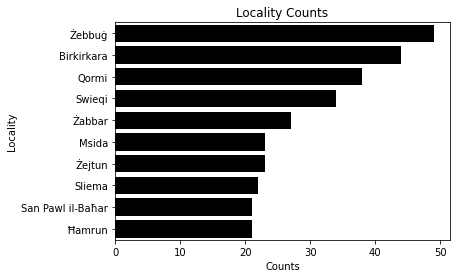

In [40]:
# Top Localities
locality_df = marketplace['Locality'].value_counts().sort_index()
locality_df = locality_df.rename_axis('Locality').reset_index(name='Counts').sort_values(by='Counts', ascending=False)
locality_top = locality_df.head(10)

sns.barplot(x = 'Counts', y = 'Locality', data = locality_top, color = "black").set(title='Locality Counts')

All top localities are in Malta, despite having some observations listed in Gozo.

In [41]:
# Check for any Price difference between Localities
marketplace.groupby(['Locality'])['Price'].agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
Locality,,,,
Attard,16,8750.000000,4350.0,9721.248205
Balzan,12,10775.000000,4400.0,10368.385076
Birgu,5,3260.000000,3500.0,1089.954127
Birkirkara,44,6592.500000,4800.0,6448.545942
Birżebbuġa,13,5223.076923,2800.0,6482.560431
Bormla,6,4666.500000,4649.5,2819.782527
Fgura,15,4523.333333,3850.0,3553.412176
Gudja,3,5026.666667,3580.0,4912.446777
Għajnsielem,3,2966.666667,3400.0,838.649708


An inspection of prices by locality indicates that second hand car sales follow similar price patterns to other purchases, where prices tend to be higher in the North, Northern Harbour and West regions of Malta, and prices are lower in Gozo. Nevertheless, some localities appear to be exceptions to this local rule of thumb. 

### Save Cleaned Data

In [42]:
marketplace.columns

Index(['Title', 'Price', 'Locality', 'Description', 'Condition', 'Text',
       'Text_Clean', 'Transmission', 'Fuel', 'Diesel', 'Petrol', 'Electric',
       'Hybrid', 'Used - like new', 'Used - good', 'For Scrap'],
      dtype='object')

In [43]:
# Drop Working Columns
marketplace = marketplace.drop(['Title', 'Description', 'Text_Clean', 'Diesel', 'Petrol', 'Electric', 'Hybrid', 'Used - like new', 
                                'Used - good', 'For Scrap'], axis=1)

print('Final Dataframe Shape :', marketplace.shape)
marketplace.head()

Final Dataframe Shape : (603, 6)


,Price,Locality,Condition,Text,Transmission,Fuel
0,4999.0,Żejtun,Used - like new,🚨🚨Cars For Sale 🚨🚨 📞📞77226444,Manual,Unknown
1,2750.0,Munxar,Used - Good,Renault Megane Scenic 16 Petrol Automatic . Ta...,Automatic,Petrol
2,4800.0,Birkirkara,Used - Good,Suzuki swift Suzuki swift in good condition 2008,Manual,Unknown
3,4500.0,Birkirkara,Used - Good,99882200 FOR SALE MOB 📞📞 99882200 TOYOTA VITZ ...,Automatic,Petrol
4,3000.0,Marsaskala,Used - Fair,Car for sale If you are interested dm me,Manual,Unknown


In [44]:
# Save Cleaned Dataframe
marketplace.to_csv('cars_clean_data.csv', index=False)